In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import numpy as np


In [8]:
# Dataset path
dataset_path = r"C:\Users\HP\OneDrive\Desktop\Minor Project 6 th sem\dataset\farm_insects"

In [9]:
# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

In [10]:
# Fix PIL transparency issue
def convert_image(img):
    if isinstance(img, np.ndarray):  # Check if input is already an image array
        return img
    img = Image.open(img)
    if img.mode in ("P", "RGBA"):  # Convert Palette/Transparent images to RGB
        img = img.convert("RGB")
    return np.array(img)

In [11]:
# Data augmentation (removed `preprocessing_function` to avoid error)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

In [12]:
# Load training data
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

Found 1269 images belonging to 14 classes.


In [13]:
# Load validation data
val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 310 images belonging to 14 classes.


In [14]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [15]:
# Enable fine-tuning for better learning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

In [16]:
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

In [17]:
# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

In [18]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [20]:
# Train the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\HP\OneDrive\Desktop\Code\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


c:\Users\HP\OneDrive\Desktop\Code\venv\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1504s 30s/step - accuracy: 0.1047 - loss: 2.6388 - val_accuracy: 0.2032 - val_loss: 2.4489 - learning_rate: 1.0000e-04
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1197s 30s/step - accuracy: 0.2269 - loss: 2.3650 - val_accuracy: 0.4097 - val_loss: 1.9696 - learning_rate: 1.0000e-04
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 737s 18s/step - accuracy: 0.3760 - loss: 1.9342 - val_accuracy: 0.5871 - val_loss: 1.5317 - learning_rate: 1.0000e-04
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 654s 16s/step - accuracy: 0.5669 - loss: 1.4965 - val_accuracy: 0.6097 - val_loss: 1.2723 - learning_rate: 1.0000e-04
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 661s 16s/step - accuracy: 0.6408 - loss: 1.1897 - val_accuracy: 0.6710 - val_loss: 1.1139 - learning_rate: 1.0000e-04
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 633s 16s/step - accuracy: 0.7422 - loss: 0.9120 - val_accuracy: 0.6613 - val_loss: 1.0228 - learning_rate: 1.0000e-04
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 659s 16s/step - accuracy: 0.7407 - 

In [21]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 94s 9s/step - accuracy: 0.7192 - loss: 0.9958
Validation Accuracy: 72.26%


In [22]:
# Save the model
model.save("pest_detection_model3_v2.h5")

In [23]:
import matplotlib.pyplot as plt

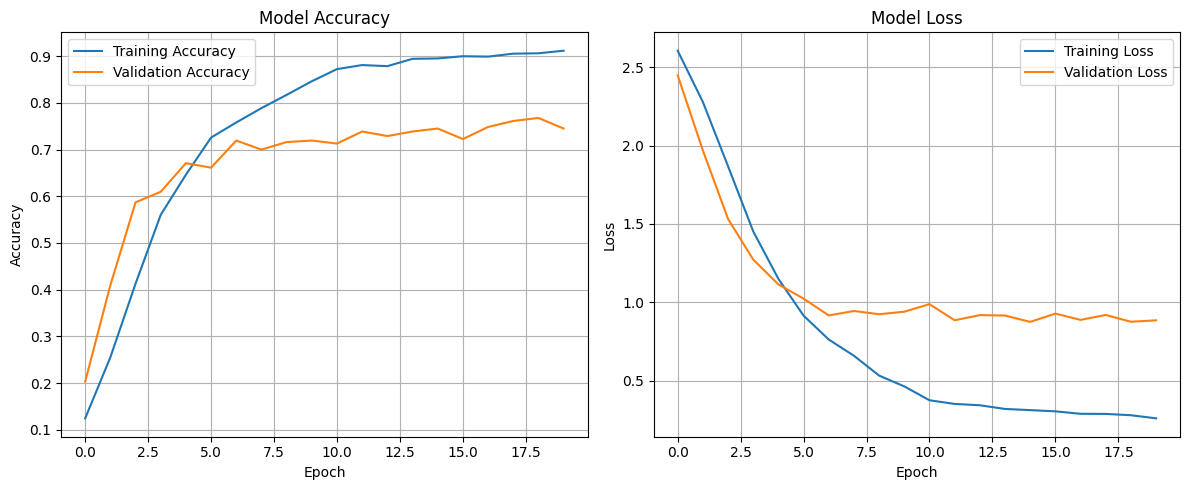

In [24]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [26]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")

Final Training Accuracy: 0.9117


In [28]:
from sklearn.metrics import confusion_matrix


In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

 5/10 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step

c:\Users\HP\OneDrive\Desktop\Code\venv\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step


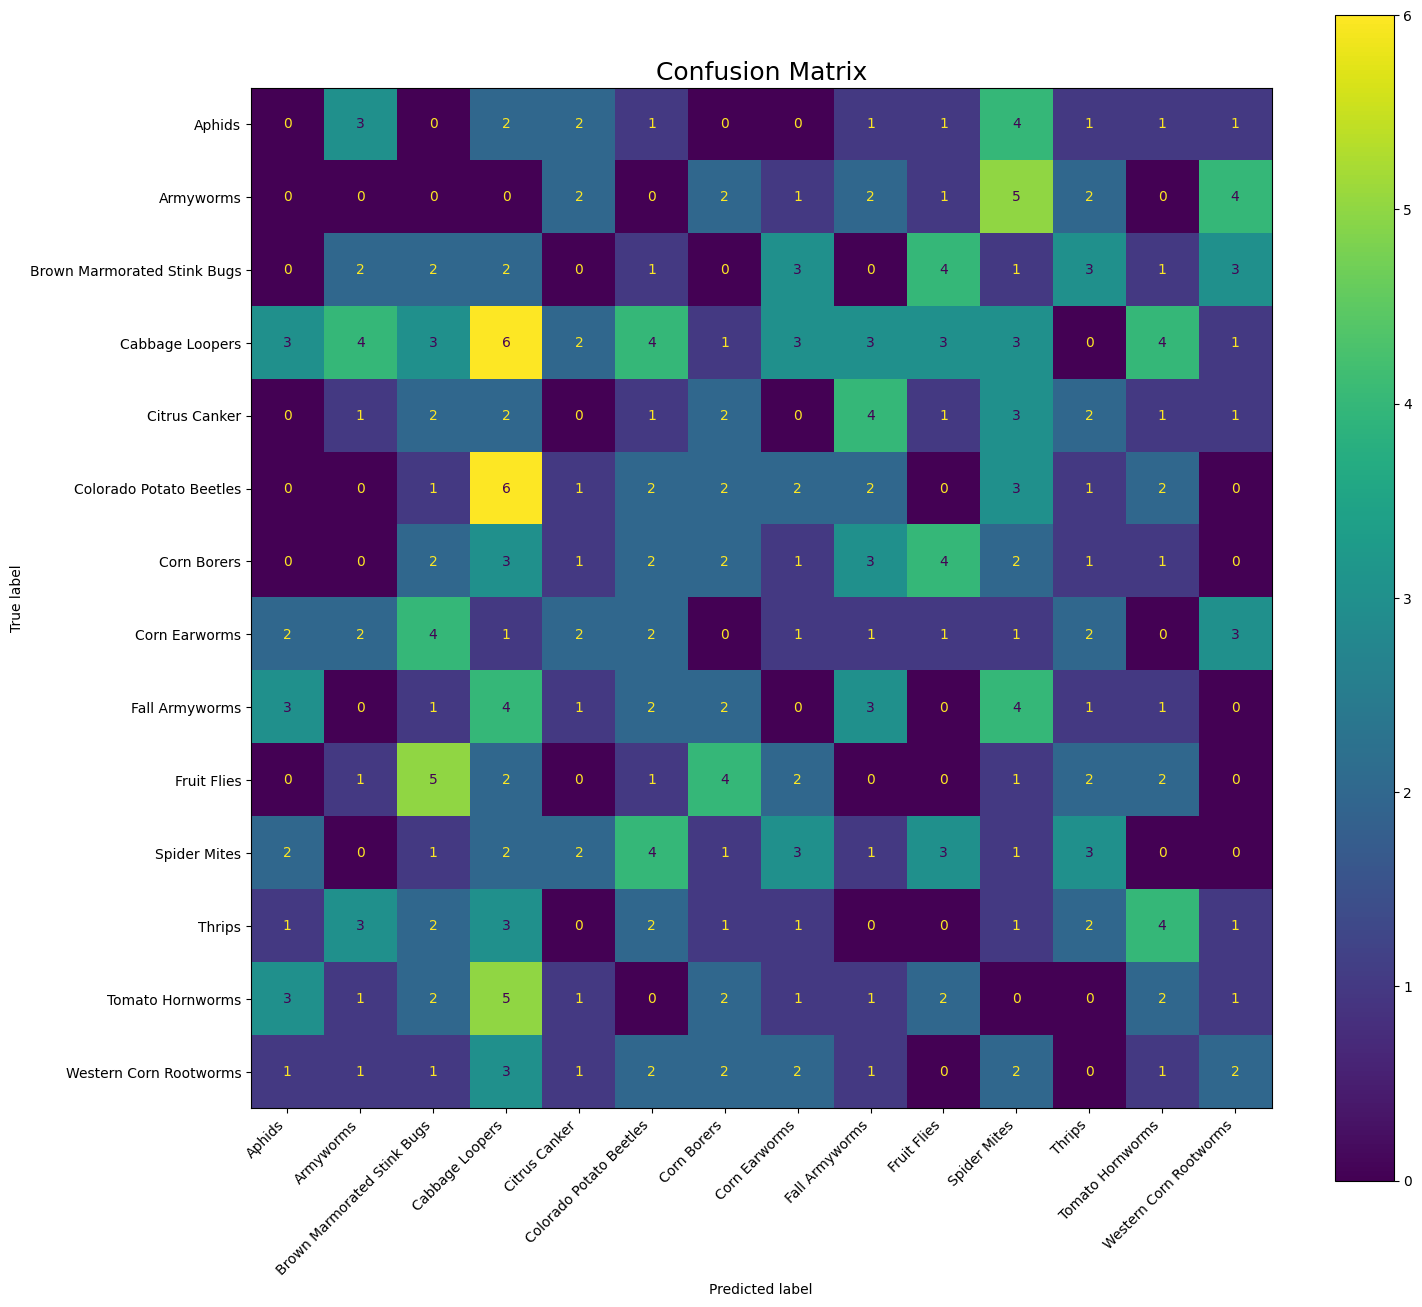

In [ ]:

val_data.reset()

# Predict and get class indices
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot with more space
fig, ax = plt.subplots(figsize=(16, 14))  # Larger figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(
    cmap='viridis',
    xticks_rotation=45,
    values_format='d',
    ax=ax
)
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout(pad=3.0)  # Add padding to avoid cutoff
plt.grid(False)
plt.show()